In [21]:
import pandas as pd
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from IPython.display import Image
from subprocess import call
import shap
from sklearn.metrics import accuracy_score
import joblib
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_tree, plot_importance
import xgboost as xgb
from xgboost import plot_tree, plot_importance
import geopandas as gpd

with open('./token.txt', 'r') as f:
    TOKEN = f.read()
    px.set_mapbox_access_token(TOKEN)

In [22]:
def parse_time(value):
    hours = value // 100
    minutes = value % 100
    return pd.to_timedelta(f"{hours} hours {minutes} minutes")

def encodeCategorical(df):
    df_encoded = df.copy()
    df_encoded['daynight'] = df_encoded['daynight'].apply(lambda x: 1 if x != 'D' else 0)
    df_encoded['satellite'] = df_encoded['satellite'].apply(lambda x: 0 if x == 'N' else 1 if x == '1' else 2 if x == 'Terra' else 3)
    df_encoded['confidence'] = df_encoded['confidence'].apply(lambda x: 0 if x == 'l' else 1 if x == 'n' else 2 if x == 'h' else 3)
    return df_encoded

def featureEngineering(df):
    X = df.copy()

    # Time
    X['acq_date'] = pd.to_datetime(X['acq_date'])
    X['year'] = X['acq_date'].dt.month
    X['month'] = X['acq_date'].dt.month
    X['day'] = X['acq_date'].dt.day
    X['weekday'] = X['acq_date'].dt.weekday
    X['hour'] = X['acq_time'].apply(parse_time).dt.components.hours

    if 'comuna' in X.columns:        
        # Grouping stats frp by comuna, year, month
        mean_frp = X.groupby(['comuna', 'year', 'month'])['frp'].mean()
        X['mean_frp'] = X.apply(lambda row: mean_frp[row['comuna'], row['year'], row['month']], axis=1)

        max_frp = X.groupby(['comuna', 'year', 'month'])['frp'].max()
        X['max_frp'] = X.apply(lambda row: max_frp[row['comuna'], row['year'], row['month']], axis=1)

        min_frp = X.groupby(['comuna', 'year', 'month'])['frp'].min()
        X['min_frp'] = X.apply(lambda row: min_frp[row['comuna'], row['year'], row['month']], axis=1)

        # Grouping stats frp by comuna, year, month, day
        mean_frp = X.groupby(['comuna', 'year', 'month', 'day'])['frp'].mean()
        X['mean_frp_day'] = X.apply(lambda row: mean_frp[row['comuna'], row['year'], row['month'], row['day']], axis=1)

        max_frp = X.groupby(['comuna', 'year', 'month', 'day'])['frp'].max()
        X['max_frp_day'] = X.apply(lambda row: max_frp[row['comuna'], row['year'], row['month'], row['day']], axis=1)

        min_frp = X.groupby(['comuna', 'year', 'month', 'day'])['frp'].min()
        X['min_frp_day'] = X.apply(lambda row: min_frp[row['comuna'], row['year'], row['month'], row['day']], axis=1)

        # std
        std_frp = X.groupby(['comuna', 'year', 'month'])['frp'].std()
        X['std_frp'] = X.apply(lambda row: std_frp[row['comuna'], row['year'], row['month']], axis=1)

    return X

def encodeComuas(df):
    comunas = gpd.read_file('../django-api/app/data/comunas.geojson')

    """
        Comunas are ordered alphabetically by default. We want to order them by latitude like rows.
        This will help the model tree to make better decisions.
        And it will also help us to visualize the results in a more intuitive way.
        There is a total of 340 comunas in Chile, if the model decides to cut by > 150, 
        we intuitively know that it is somewhat in the middle of the country.
    """
    comunas['coords'] = comunas['geometry'].apply(lambda x: x.representative_point().coords[:][0][1])
    comunas.sort_values(by='coords', inplace=True, ascending=False)
    comunas.reset_index(drop=True, inplace=True)

    comunas_index = comunas['comuna']

    if 'comuna' not in df.columns:
        print("The DataFrame does not have a 'comuna' column.")
        return
    
    if df['comuna'].isnull().any():
        print("The 'comuna' column contains null values.")
        return

    comunas_map = {}

    for i, comuna in enumerate(comunas_index):
        comunas_map[comuna] = i
        comunas_map[i] = comuna

    def encodeComuna(comuna):
        return comunas_map[comuna]

    df['comuna'] = df['comuna'].apply(encodeComuna)

    return df, comunas_map

def decodeComuna(comuna, comunas_map):
    return comunas_map[comuna]

## Preprocessing

In [23]:
df = pd.read_parquet('../django-api/app/fires_merged_comunas.parquet')

In [24]:
comunas = gpd.read_file('../django-api/app/data/comunas.geojson')

In [25]:
df = df[df['comuna'].notnull()]

In [26]:
# Not null data, aka labeled data
labeled = df[df['type'].notnull()]

In [27]:
unlabeled = df[df['type'].isnull()]

In [28]:
unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212239 entries, 269088 to 580028
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   latitude    212239 non-null  float64       
 1   longitude   212239 non-null  float64       
 2   brightness  212239 non-null  float64       
 3   scan        212239 non-null  float64       
 4   track       212239 non-null  float64       
 5   acq_date    212239 non-null  datetime64[ns]
 6   acq_time    212239 non-null  int64         
 7   satellite   212239 non-null  object        
 8   instrument  212239 non-null  object        
 9   confidence  212239 non-null  object        
 10  version     212239 non-null  object        
 11  bright_t31  212239 non-null  float64       
 12  frp         212239 non-null  float64       
 13  daynight    212239 non-null  object        
 14  type        0 non-null       float64       
 15  comuna      212239 non-null  object        
dtypes:

In [29]:
train = labeled.copy()

df_encoded = encodeCategorical(train)
df_encoded, comunas_map = encodeComuas(df_encoded)

In [30]:
df_encoded.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,comuna
0,-23.820446,-70.320282,301.51,0.74,0.76,2013-01-01,448,0,VIIRS,1,1,285.54,2.38,1,2.0,17
1,-23.823833,-70.318871,306.90,0.74,0.76,2013-01-01,448,0,VIIRS,1,1,285.80,2.33,1,2.0,17
2,-26.430983,-69.475632,299.73,0.58,0.70,2013-01-01,448,0,VIIRS,1,1,279.61,2.86,1,2.0,19
3,-32.760929,-71.476440,309.70,0.52,0.67,2013-01-01,448,0,VIIRS,1,1,285.42,2.50,1,3.0,54
4,-34.624073,-71.000023,319.97,0.44,0.63,2013-01-01,448,0,VIIRS,1,1,290.28,2.27,1,0.0,162


In [31]:
unlabeled_encoded = encodeCategorical(unlabeled)
unlabeled_encoded, comunas_map = encodeComuas(unlabeled_encoded)

In [32]:
unlabeled_encoded.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,comuna
269088,-23.36115,-67.72974,312.8,0.38,0.36,2019-12-04,536,1,VIIRS,1,2.0NRT,269.7,1.5,1,NaN,15
269089,-23.82504,-70.31619,328.4,0.43,0.38,2019-12-04,536,1,VIIRS,1,2.0NRT,287.1,1.8,1,NaN,17
269090,-23.82432,-70.32031,297.7,0.43,0.38,2019-12-04,536,1,VIIRS,1,2.0NRT,285.5,1.8,1,NaN,17
269091,-22.31535,-68.88089,328.7,0.40,0.37,2019-12-04,536,1,VIIRS,1,2.0NRT,284.9,4.0,1,NaN,13
269092,-23.36057,-67.73347,317.6,0.38,0.36,2019-12-04,536,1,VIIRS,1,2.0NRT,270.4,1.5,1,NaN,15


## Feature Engineering

In [33]:
df_encoded.shape, unlabeled_encoded.shape

((367362, 16), (212239, 16))

In [34]:
X = df_encoded.drop(columns=['type'])
y = df_encoded['type']

# convert the type = 2, 3 to 1
y = y.apply(lambda x: 1 if x > 1 else x)

In [35]:
X.columns

Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'comuna'],
      dtype='object')

In [36]:
X = featureEngineering(X)

In [37]:
X.describe().T

,count,mean,min,25%,50%,75%,max,std
latitude,367362.0,-35.177677,-53.971592,-38.0459,-36.352907,-34.105999,-17.638351,4.836638
longitude,367362.0,-71.75457,-74.153961,-72.528374,-71.987705,-71.059007,-67.057037,1.100592
brightness,367362.0,330.046338,208.0,311.95,330.91,343.52,505.8,21.375774
scan,367362.0,0.723063,0.32,0.41,0.48,0.72,4.8,0.610725
track,367362.0,0.654638,0.36,0.4,0.53,0.76,2.0,0.338199
acq_date,367362,2017-09-21 06:56:25.682786816,2013-01-01 00:00:00,2015-04-30 00:00:00,2017-02-04 00:00:00,2020-02-07 00:00:00,2023-01-31 00:00:00,NaN
acq_time,367362.0,1338.852086,230.0,554.0,1759.0,1848.0,2036.0,629.583815
satellite,367362.0,0.612118,0.0,0.0,0.0,0.0,3.0,1.130312
confidence,367362.0,1.064299,0.0,1.0,1.0,1.0,2.0,0.44943
bright_t31,367362.0,295.405492,215.7,286.65,294.29,302.62,400.1,13.001546


In [38]:
features = ['frp', 'month', 'day', 'daynight', 'mean_frp', 'std_frp', 'max_frp', 'min_frp', 'mean_frp_day', 'max_frp_day', 'min_frp_day', 'comuna']
# + ['brightness', 'bright_t31', 'comuna', 'longitude', 'latitude', 'confidence', 'daynight', 'satellite']

In [39]:
features

['frp',
 'month',
 'day',
 'daynight',
 'mean_frp',
 'std_frp',
 'max_frp',
 'min_frp',
 'mean_frp_day',
 'max_frp_day',
 'min_frp_day',
 'comuna']

## Training

In [40]:
Xn = X[features]

In [41]:
Xn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367362 entries, 0 to 465149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   frp           367362 non-null  float64
 1   month         367362 non-null  int32  
 2   day           367362 non-null  int32  
 3   daynight      367362 non-null  int64  
 4   mean_frp      367362 non-null  float64
 5   std_frp       367146 non-null  float64
 6   max_frp       367362 non-null  float64
 7   min_frp       367362 non-null  float64
 8   mean_frp_day  367362 non-null  float64
 9   max_frp_day   367362 non-null  float64
 10  min_frp_day   367362 non-null  float64
 11  comuna        367362 non-null  int64  
dtypes: float64(8), int32(2), int64(2)
memory usage: 33.6 MB


In [42]:
X_train, X_temp, y_train, y_temp = train_test_split(Xn, y, test_size=0.3, random_state=69)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=69)

In [43]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'lambda': 0.5,
    'colsample_bytree': 0.8,
    'seed': 69
}

num_rounds = 1000
watchlist = [(dtrain, 'train'), (dval, 'eval')]

model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=10)

y_pred = model.predict(dtest)

y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy on the test set: {accuracy:.4f}")

[0]	train-logloss:0.62860	eval-logloss:0.62854
[1]	train-logloss:0.57326	eval-logloss:0.57320
[2]	train-logloss:0.52660	eval-logloss:0.52659
[3]	train-logloss:0.48750	eval-logloss:0.48741
[4]	train-logloss:0.45383	eval-logloss:0.45375
[5]	train-logloss:0.42656	eval-logloss:0.42650
[6]	train-logloss:0.40129	eval-logloss:0.40129


[7]	train-logloss:0.37869	eval-logloss:0.37873
[8]	train-logloss:0.35958	eval-logloss:0.35968
[9]	train-logloss:0.34230	eval-logloss:0.34243
[10]	train-logloss:0.32724	eval-logloss:0.32743
[11]	train-logloss:0.31499	eval-logloss:0.31520
[12]	train-logloss:0.30300	eval-logloss:0.30333
[13]	train-logloss:0.29241	eval-logloss:0.29270
[14]	train-logloss:0.28363	eval-logloss:0.28391
[15]	train-logloss:0.27530	eval-logloss:0.27556
[16]	train-logloss:0.26690	eval-logloss:0.26720
[17]	train-logloss:0.26120	eval-logloss:0.26147
[18]	train-logloss:0.25548	eval-logloss:0.25576
[19]	train-logloss:0.25044	eval-logloss:0.25074
[20]	train-logloss:0.24470	eval-logloss:0.24499
[21]	train-logloss:0.23967	eval-logloss:0.23995
[22]	train-logloss:0.23592	eval-logloss:0.23624
[23]	train-logloss:0.23188	eval-logloss:0.23220
[24]	train-logloss:0.22840	eval-logloss:0.22883
[25]	train-logloss:0.22555	eval-logloss:0.22601
[26]	train-logloss:0.22258	eval-logloss:0.22308
[27]	train-logloss:0.22040	eval-logloss:0.2

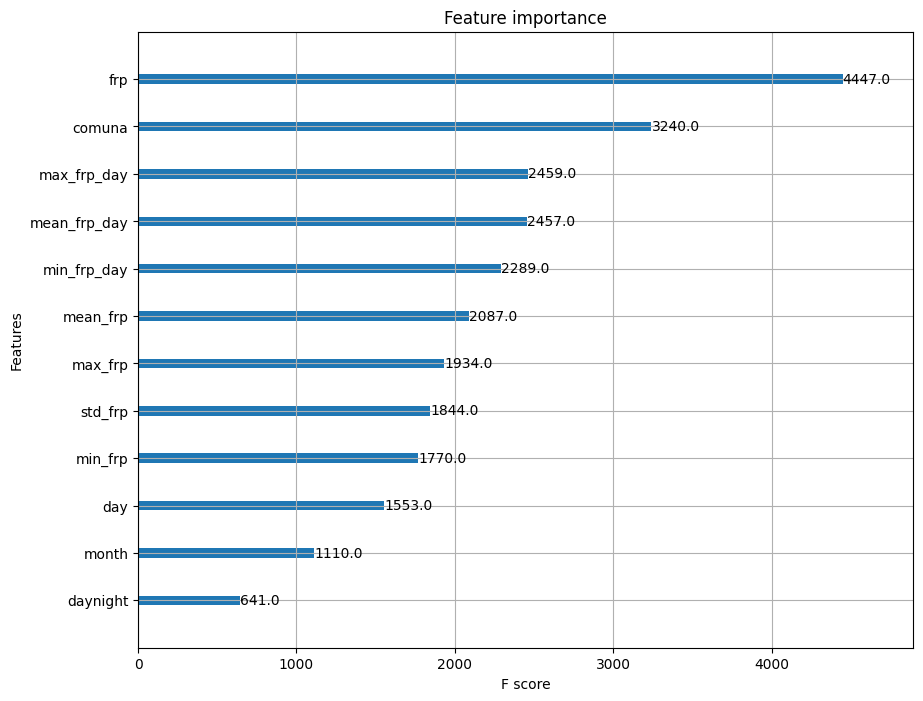

In [44]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, ax=ax)
plt.show()

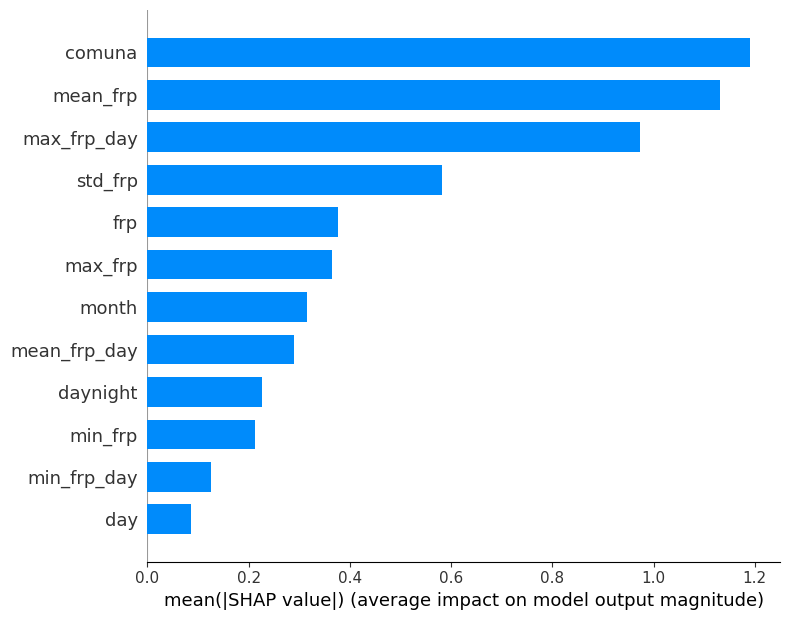

In [45]:
# Explain the model's predictions using SHAP values and a subset
# of the test data
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


<AxesSubplot: >

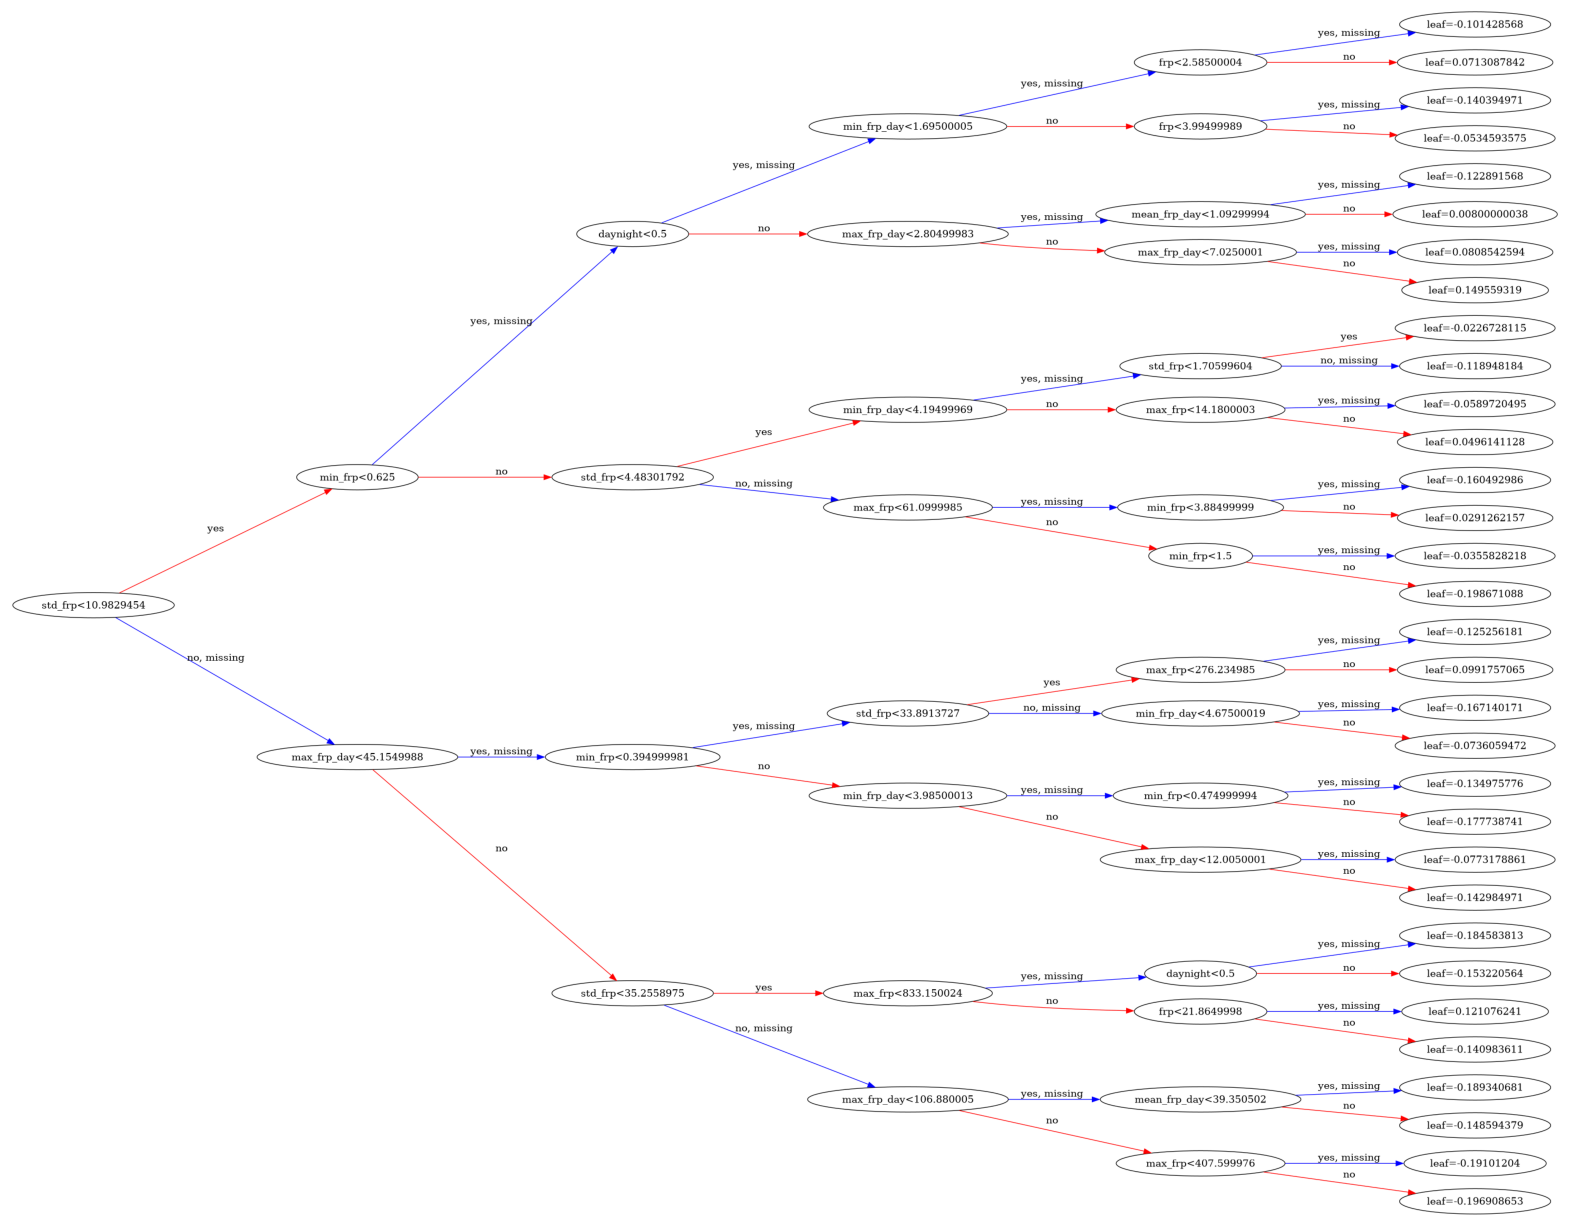

In [46]:
# Plot xgboost tree
fig, ax = plt.subplots(figsize=(20, 20))
plot_tree(model, rankdir='LR', num_trees=0, ax=ax)

In [47]:
#cv_results = xgb.cv(params, dtrain, num_rounds, nfold=5, metrics='auc', seed=123)
#cv_results

In [48]:
test_points = [
    {
        "id": 590374,  # Villarica volcano
        "latitude": -39.42183,
        "longitude": -71.94198,
        "brightness": 306.85,
        "scan": 0.43,
        "track": 0.62,
        "acq_date": "2024-02-09",
        "acq_time": 635,
        "satellite": "1",
        "instrument": "VIIRS",
        "confidence": "n",
        "version": "2.0NRT",
        "bright_t31": 273.43,
        "frp": 4.76,
        "daynight": "N",
        "ftype": 0,
        "comuna": "PANGUIPULLI"
    },
    {
        "id": 590360,  # Planta Celulosa
        "latitude": -37.51465,
        "longitude": -72.65443,
        "brightness": 300.86,
        "scan": 0.39,
        "track": 0.36,
        "acq_date": "2024-02-09",
        "acq_time": 546,
        "satellite": "N",
        "instrument": "VIIRS",
        "confidence": "n",
        "version": "2.0NRT",
        "bright_t31": 290.3,
        "frp": 0.71,
        "daynight": "N",
        "ftype": 0,
        "comuna": "NACIMIENTO"
    },
    {
        "id": 590377,  # solarpanels
        "latitude": -26.36621,
        "longitude": -70.07008,
        "brightness": 326.91,
        "scan": 1.31,
        "track": 1.14,
        "acq_date": "2024-02-09",
        "acq_time": 1403,
        "satellite": "Terra",
        "instrument": "MODIS",
        "confidence": "n",
        "version": "6.1NRT",
        "bright_t31": 310.38,
        "frp": 10.38,
        "daynight": "D",
        "ftype": 0,
        "comuna": "CHANARAL"
    }
]

In [49]:
test_points_fake = [
      {
    "id": 589888,
    "latitude": -34.7845,
    "longitude": -71.01165,
    "brightness": 304.21,
    "scan": 0,
    "track": 0,
    "acq_date": "2024-02-08",
    "acq_time": 512,
    "satellite": "1",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 289.1,
    "frp": 0,
    "daynight": "N",
    "ftype": 0,
    "comuna": "AISEN"
  }
]

In [50]:
new_data = pd.DataFrame(test_points)
new_data_encoded = featureEngineering(new_data)
new_data_encoded = encodeCategorical(new_data_encoded)
new_data_encoded, comunas_map = encodeComuas(new_data_encoded)

new_data_encoded = new_data_encoded[features]

new_data_dmatrix = xgb.DMatrix(new_data_encoded)
new_data_pred = model.predict(new_data_dmatrix)

print(new_data_pred)
new_data_pred = [1 if pred > 0.5 else 0 for pred in new_data_pred]
print(new_data_pred)

[0.17453235 0.00074924 0.02700392]
[0, 0, 0]


In [51]:
# Export model
model.save_model('./models/xgboost_comunas.model')